In [1]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import json

from collections import OrderedDict

import torch
import torch.nn as nn

from sklearn.preprocessing import OneHotEncoder
import numpy as np

from pkg_resources import packaging


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

C:\Users\AlexTerentowicz\AppData\Local\Temp\ipykernel_23232\2567773326.py:17: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging


In [2]:
print("Torch version:", torch.__version__)
print(torch. cuda. is_available())
print("CUDA version:", torch.version.cuda)

Torch version: 2.3.0+cu118
True
CUDA version: 11.8


#### Load features

In [3]:
frame_types = ["frame_first", "frame_half", "frame_last", "comic_3", "comic_4"]
frame_type = frame_types[4]
path = f'./data/features/{frame_type}'
image_features = torch.load(f'{path}/image_features.pt')
text_features = torch.load(f'{path}/text_features.pt')

X = torch.cat((image_features, text_features), dim=1)
X.shape

torch.Size([9966, 1024])

#### Prepare labels

In [4]:
with open('data/Subtask_2_train.json') as f:
    text_data_list = json.load(f)
    # text data is a map of conversation id to conversation
    text_data = {text['conversation_ID']: text for text in text_data_list}

missing_encodings = {frame_type: [] for frame_type in frame_types}

for frame_type in frame_types:
    path = f'./data/features/{frame_type}'
    encoded_convs_utts = torch.load(f'{path}/encoded_convs_utts.pt')
    for c_id, conv in text_data.items():
        for utt in conv['conversation']:
            u_id = utt['utterance_ID']
            if (c_id, u_id) not in encoded_convs_utts:
                missing_encodings[frame_type].append((c_id, u_id))

    print(f"{frame_type} missing encodings: {len(missing_encodings[frame_type])}")

text_data_filtered = text_data.copy()
for c_id, conv in text_data.items():
    text_data_filtered[c_id]['conversation'] = [utt for utt in conv['conversation'] if (c_id, utt['utterance_ID']) not in missing_encodings[frame_types[4]]]

n_utts = 0
labels = []
for c_id, conv in text_data_filtered.items():
    n_utts += len(conv['conversation'])
    labels += [utt['emotion'] for utt in conv['conversation']]

frame_first missing encodings: 3653
frame_half missing encodings: 3653
frame_last missing encodings: 3653
comic_3 missing encodings: 3653
comic_4 missing encodings: 3653


In [13]:
onehot_encoder = OneHotEncoder()
Y = onehot_encoder.fit_transform(np.array(labels).reshape(-1, 1))
Y = torch.tensor(Y.toarray()).cuda()
dict(enumerate(onehot_encoder.categories_[0]))

{0: 'anger',
 1: 'disgust',
 2: 'fear',
 3: 'joy',
 4: 'neutral',
 5: 'sadness',
 6: 'surprise'}

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X.cpu().numpy(), Y.cpu().numpy(), test_size=0.2, random_state=42)

X_train = torch.tensor(X_train).cuda()
X_test = torch.tensor(X_test).cuda()
Y_train = torch.tensor(Y_train).cuda()
Y_test = torch.tensor(Y_test).cuda()

# shapes
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

torch.Size([7972, 1024]) torch.Size([7972, 7])
torch.Size([1994, 1024]) torch.Size([1994, 7])


## Define model

In [59]:
model_name = 'simple-clip-emoclsf-2'

os.makedirs(f'./experiments/plots/{model_name}', exist_ok=True)

class ClipEmotionClassifier(nn.Module):
    def __init__(self):
        super(ClipEmotionClassifier, self).__init__()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 7)


    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Train the model

In [9]:
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.rc('figure', figsize=(9, 5))

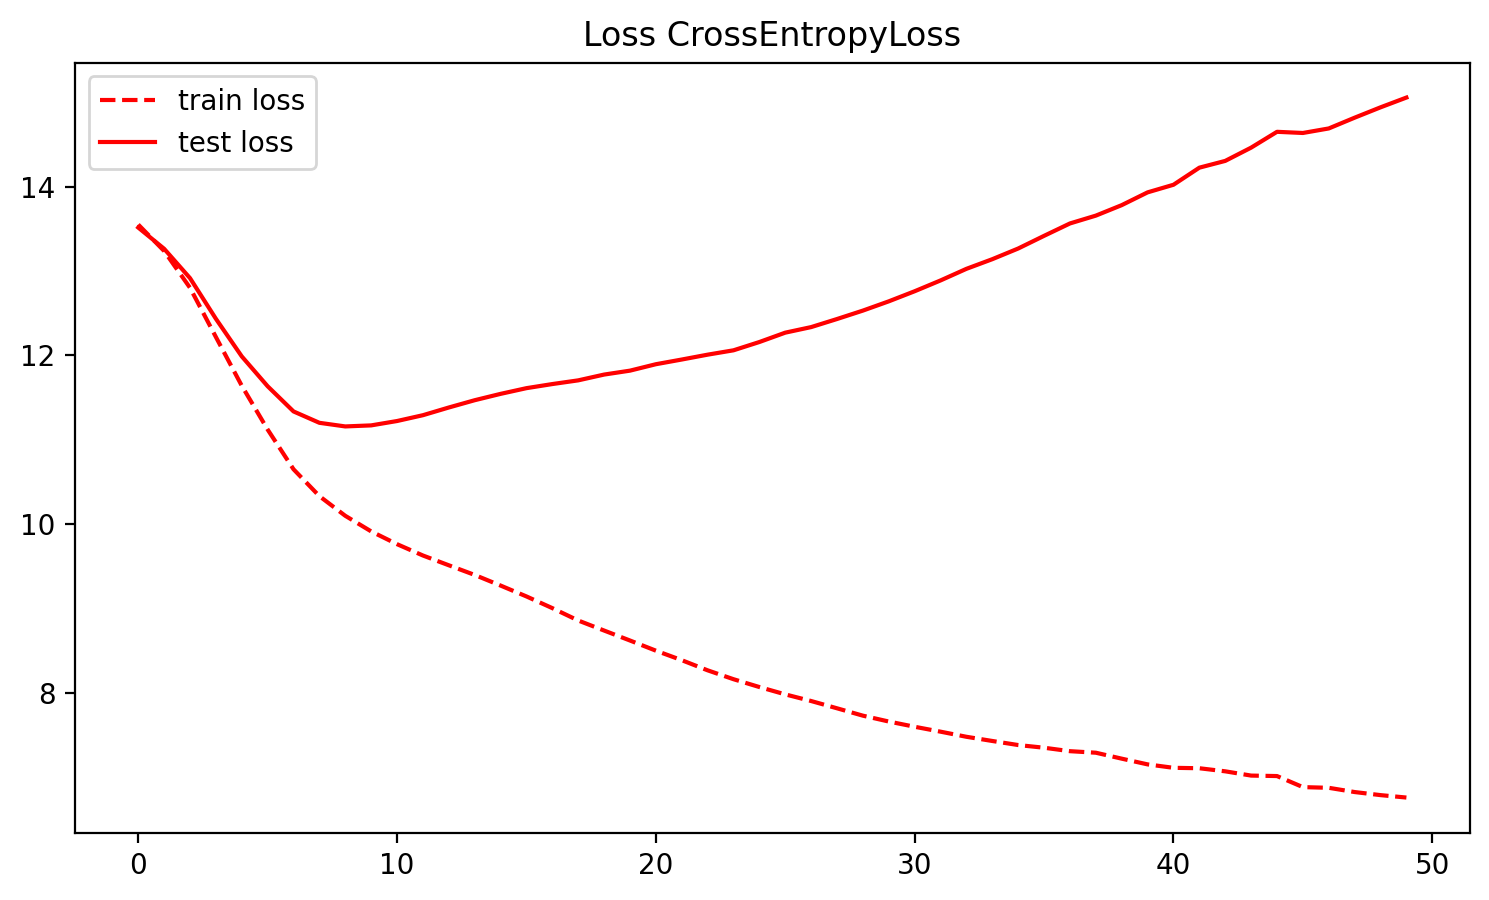

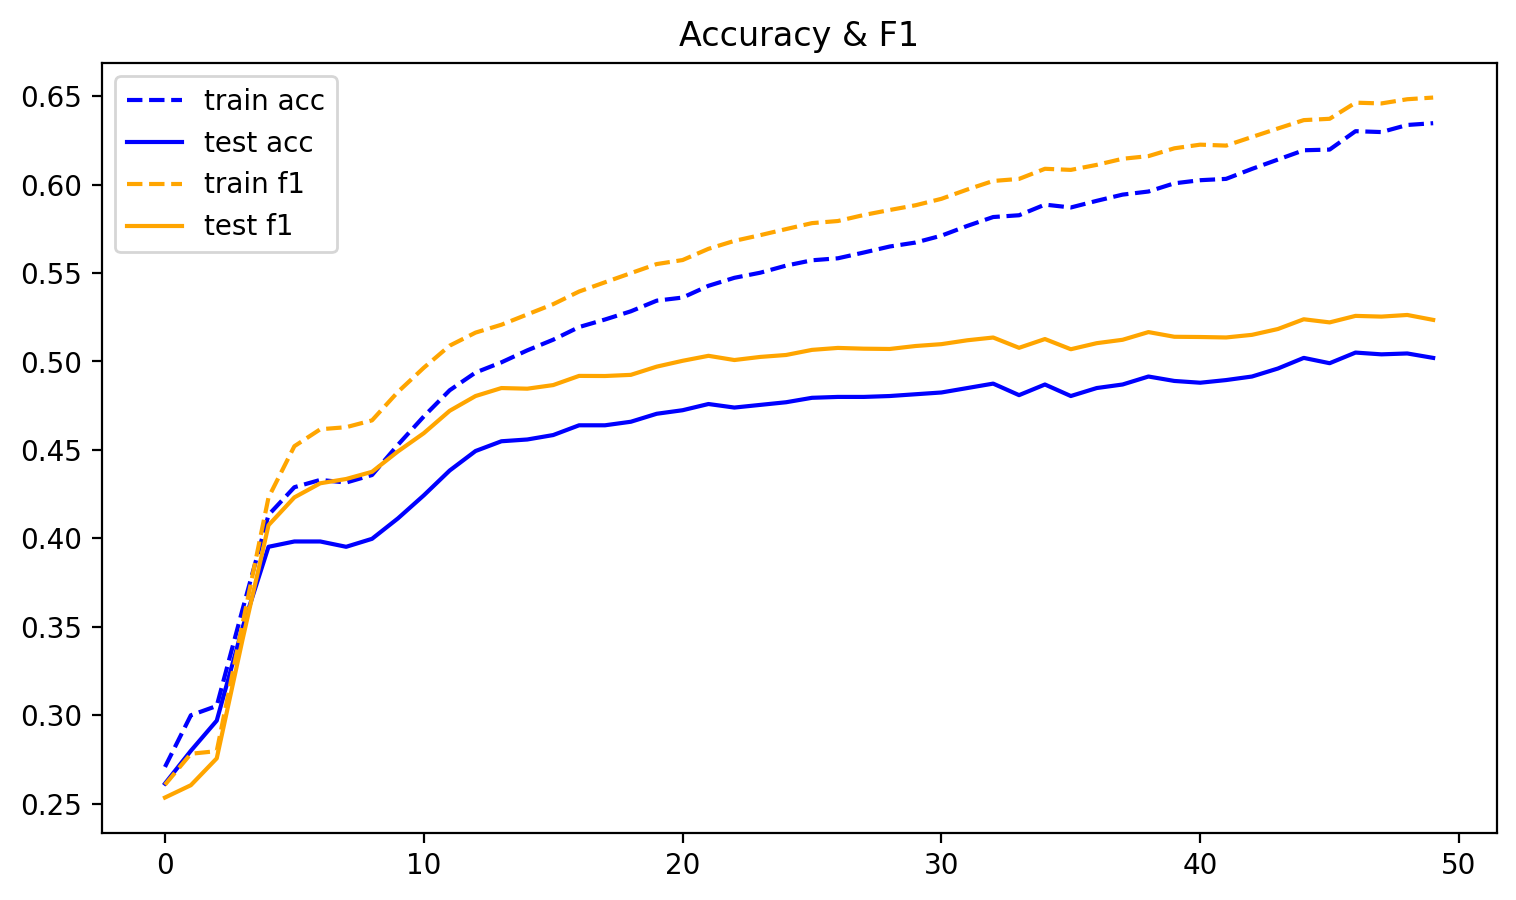

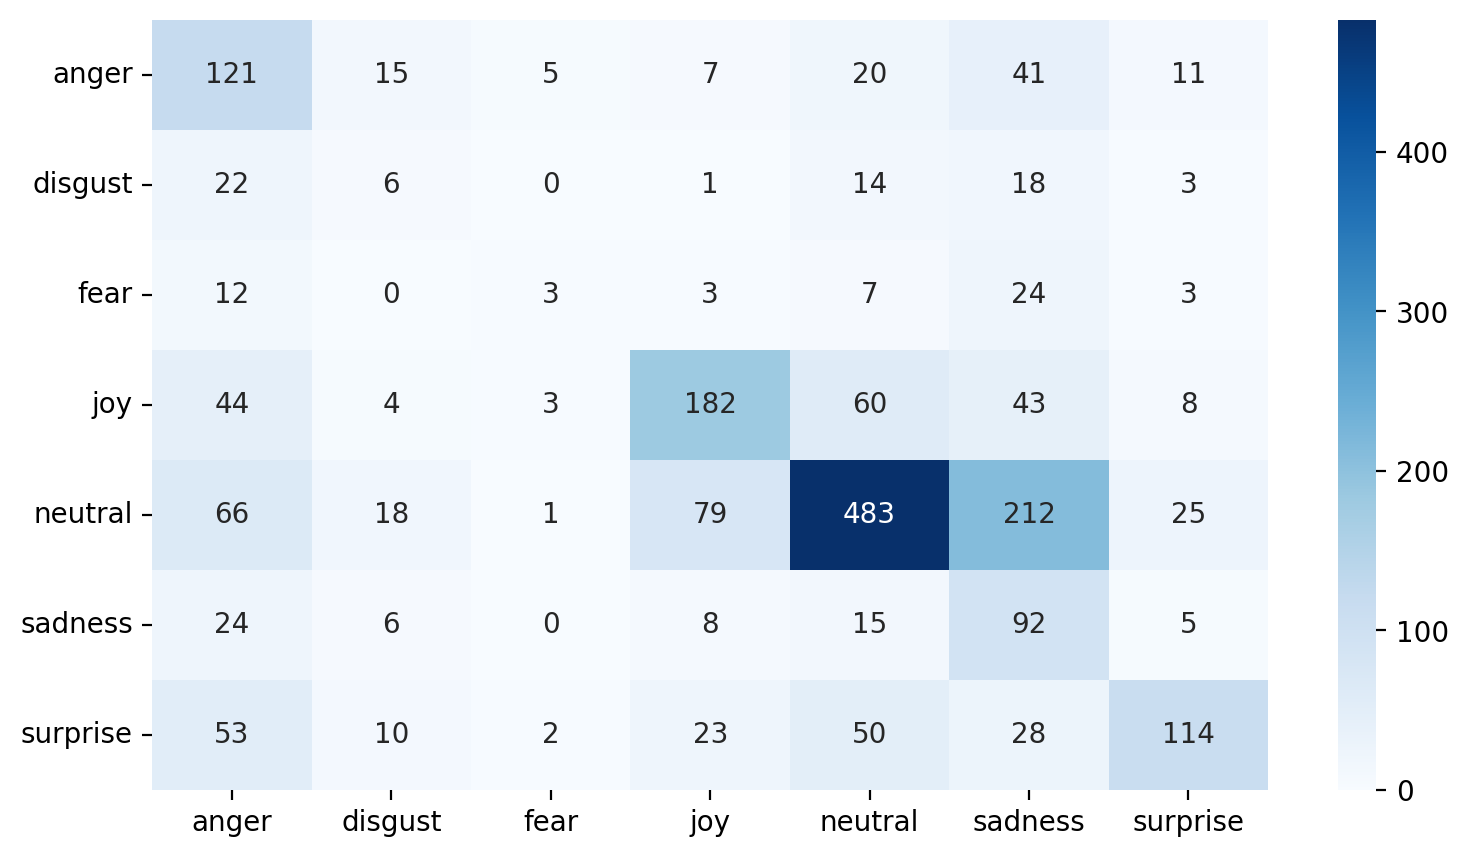

In [58]:
# Define training parameters

model = ClipEmotionClassifier().cuda()
model

# weighted cross entropy loss
class_counts = Y.sum(dim=0)
class_percents = class_counts / class_counts.sum()

# weights = 1 / class_percents
# weights = weights / weights.sum()
# weights = weights.tolist()

weights = [len(Y) / float(c_count) for c_count in class_counts]

criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights).cuda())

optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

n_epochs = 50
batch_size = 128
n_batches = X_train.shape[0] // batch_size
train_losses, test_losses = [], [] 
train_accuracies, test_accuracies = [], []
train_f1_scores, test_f1_scores = [], []

# save training parameters in json
training_params = {
    'n_epochs': n_epochs,
    'batch_size': batch_size,
    'n_batches': n_batches,
    'optimizer': {
        'name': optimizer.__class__.__name__,
        'lr': optimizer.param_groups[0]['lr'],
        'momentum': optimizer.param_groups[0]['momentum']
    },
    'criterion': criterion.__class__.__name__,
    'weights': weights
}
with open(f'./experiments/models/{model_name}.json', 'w') as f:
    json.dump(training_params, f)


for epoch in range(n_epochs):
    running_loss = 0.0
    for i in range(n_batches):
        optimizer.zero_grad()
        outputs = model(X_train[i*batch_size:(i+1)*batch_size])

        loss = criterion(outputs, torch.argmax(Y_train[i*batch_size:(i+1)*batch_size], dim=1))
        # print(loss.cpu().detach().numpy())
        
        loss.backward()
        optimizer.step()

        # if i % 10 == 9:
        #     print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 10}")
        #     running_loss = 0.0
    
    with torch.no_grad():
        train_outputs = model(X_train)
        test_outputs = model(X_test)

        train_loss = criterion(train_outputs, Y_train.float()).cpu().numpy()
        test_loss = criterion(test_outputs, Y_test.float()).cpu().numpy()

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        clear_output(wait=True)
        
        plt.figure()
        plt.title(f'Loss {criterion.__class__.__name__}')
        plt.plot(train_losses, label='train loss', color='red', linestyle='dashed')
        plt.plot(test_losses, label='test loss', color='red')
        plt.legend()
        plt.savefig(f'./experiments/plots/{model_name}/{criterion.__class__.__name__}.png')
        plt.show()

        train_acc = torch.sum(torch.argmax(train_outputs, dim=1) == torch.argmax(Y_train, dim=1)).cpu().numpy() / len(Y_train)
        test_acc = torch.sum(torch.argmax(test_outputs, dim=1) == torch.argmax(Y_test, dim=1)).cpu().numpy() / len(Y_test)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        # f1 scores
        train_f1 = f1_score(torch.argmax(Y_train.cpu(), dim=1), torch.argmax(train_outputs.cpu(), dim=1), average='weighted')
        test_f1 = f1_score(torch.argmax(Y_test.cpu(), dim=1), torch.argmax(test_outputs.cpu(), dim=1), average='weighted')
        train_f1_scores.append(train_f1)
        test_f1_scores.append(test_f1)

        plt.figure()
        plt.title('Accuracy & F1')
        plt.plot(train_accuracies, label='train acc', color='blue', linestyle='dashed')
        plt.plot(test_accuracies, label='test acc', color='blue')
        plt.plot(train_f1_scores, label='train f1', color='orange', linestyle='dashed')
        plt.plot(test_f1_scores, label='test f1', color='orange')
        plt.legend()
        plt.savefig(f'./experiments/plots/{model_name}/AccuracyF1.png')
        plt.show()

        cm = confusion_matrix(torch.argmax(Y_test.cpu(), dim=1), torch.argmax(test_outputs.cpu(), dim=1))
        plt.figure()
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=onehot_encoder.categories_[0], yticklabels=onehot_encoder.categories_[0])
        plt.savefig(f'./experiments/plots/{model_name}/confusion_matrix.png')
        plt.show()
        


# save final model
torch.save(model, f'./experiments/models/{model_name}.pt')